In [25]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import time
from tqdm import tqdm, trange
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch.nn.functional as F

## Q1: CIFAR10

In [2]:
# reference link: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

### Spilit, verctorize and encode labels

In [3]:
# transform to [0,1]
transform_1 = transforms.ToTensor()
# transform to [-1,1]
transform_2 = transforms.Normalize(mean = (0.5,0.5,0.5),std = (0.5,0.5,0.5))
# transform 
transform = transforms.Compose([transform_1,transform_2])
# set the batch_size
batch_size = 20

# get and download the CIFAR10data --- Train data
train_set = torchvision.datasets.CIFAR10(root='./CIFAR10data', train=True,
                                        download=True, transform=transform)

# get and download the CIFAR10data --- Test data
test_set = torchvision.datasets.CIFAR10(root='./CIFAR10data', train=False,
                                       download=True, transform=transform)

# split and shuffle --- Test data
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

# class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# split to training and validation, refer link: https://blog.csdn.net/weixin_43914889/article/details/104677675
indices = range(len(train_set))
print(indices)
indices_val = indices[:500]
indices_train = indices[500:]
# split to val and train
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_train = torch.utils.data.sampler.SubsetRandomSampler(indices_train)

validationloader = torch.utils.data.DataLoader(dataset =train_set, batch_size=batch_size
                                               ,sampler = sampler_val, num_workers=0)
trainloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size
                                          ,sampler = sampler_train, num_workers=0)


range(0, 50000)


In [5]:
# show the matrix of image, for example, one batch_size
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    break

In [6]:
# show the matrix of image, for example, one batch_size
print("train_batch_shape:",inputs.shape)
print(labels)
print("the labels of one batch:",[classes[i] for i in labels.numpy().tolist()])
print("the matrix of images in one batch:\n",inputs)

train_batch_shape: torch.Size([20, 3, 32, 32])
tensor([7, 4, 6, 5, 0, 8, 9, 9, 4, 6, 4, 5, 5, 4, 5, 0, 7, 9, 4, 2])
the labels of one batch: ['horse', 'deer', 'frog', 'dog', 'plane', 'ship', 'truck', 'truck', 'deer', 'frog', 'deer', 'dog', 'dog', 'deer', 'dog', 'plane', 'horse', 'truck', 'deer', 'bird']
the matrix of images in one batch:
 tensor([[[[-0.4353, -0.6000, -0.5922,  ..., -0.4745, -0.6078, -0.6235],
          [-0.5137, -0.6392, -0.6314,  ..., -0.5686, -0.5451, -0.5529],
          [-0.5216, -0.5216, -0.5451,  ..., -0.5373, -0.5216, -0.5922],
          ...,
          [ 0.6078,  0.6078,  0.6078,  ..., -0.2078, -0.1843, -0.1686],
          [ 0.5686,  0.5451,  0.5373,  ..., -0.5059, -0.4980, -0.4510],
          [ 0.4588,  0.4824,  0.4431,  ..., -0.6314, -0.6314, -0.5373]],

         [[-0.3647, -0.4980, -0.4588,  ..., -0.4118, -0.5373, -0.5373],
          [-0.4588, -0.5529, -0.5137,  ..., -0.5216, -0.4824, -0.4667],
          [-0.4824, -0.4510, -0.4510,  ..., -0.4980, -0.4824, -0.5

          [ 0.2706,  0.2627,  0.3098,  ...,  0.1216,  0.1059,  0.1294]]]])


### Show the input image

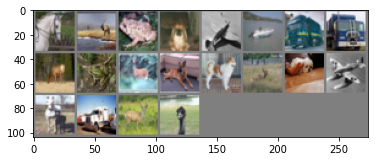

the labels of one batch: ['horse', 'deer', 'frog', 'dog', 'plane', 'ship', 'truck', 'truck', 'deer', 'frog', 'deer', 'dog', 'dog', 'deer', 'dog', 'plane', 'horse', 'truck', 'deer', 'bird']


In [7]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get data of one batch
images, labels = inputs, labels

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("the labels of one batch:",[classes[i] for i in labels.numpy().tolist()])

### Fully Connected Network Model Set

In [8]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 768),
            nn.ReLU(),
            nn.Linear(768, 384),
            nn.ReLU(),
            nn.Linear(384, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

net = NeuralNetwork()

In [9]:
# show the information of the NN
print("NN Model Information:",net)

NN Model Information: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=768, bias=True)
    (1): ReLU()
    (2): Linear(in_features=768, out_features=384, bias=True)
    (3): ReLU()
    (4): Linear(in_features=384, out_features=10, bias=True)
  )
)


In [10]:
# visualize the layer,download the pdf
import torch
from torchviz import make_dot
x = torch.rand(20,3,32,32)
g = make_dot(net(x))
g.render('CIFAR10_NN_Model', view=True)

'CIFAR10_NN_Model.pdf'

In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
# create the required list
loss_list = []
acc_list = []
loss_list_val = []
acc_list_val = []
interation_times = 0

In [13]:
# compute acc
def compute_acc(outputs, labels):
    max_list = []
    tmp_list = []
    _, predicted = torch.max(outputs, 1)
    max_list = predicted.tolist()
    for i in range(len(max_list)):
        if max_list[i] == labels[i]:
            tmp_list.append(1)
        else:
            tmp_list.append(0)
    return sum(tmp_list)/len(tmp_list)

In [14]:
for epoch in tqdm(range(5)): 
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the training data
        inputs, labels = data
        # initilize the parameter
        optimizer.zero_grad()

        # forward,backward and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # record statistics
        interation_times += 1
        running_loss += loss.item()
        running_acc += compute_acc(outputs, labels)
        if i % 100 == 99:
            loss_list.append([running_loss / 100,interation_times])
            acc_list.append([running_acc / 100,interation_times])
            running_loss = 0.0
            running_acc = 0.0
            
            #validation
            loss_val = 0; correct_val = 0; total = 0
            for data in validationloader:
                images, labels = data
                outputs = net(images)
                loss_val += criterion(outputs, labels).item()
                correct_val += compute_acc(outputs, labels)
                total += 1

            loss_list_val.append([loss_val / total,interation_times])
            acc_list_val.append([correct_val / total,interation_times])
                
print('Finished Training')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:37<00:00, 55.51s/it]


Finished Training


Text(0.5, 1.0, 'cost for NN training')

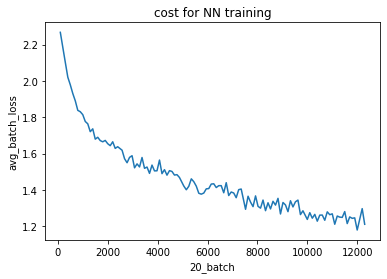

In [15]:
# draw the CNN training cost
iteration_loss_list = loss_list

# draw plot 
plt.plot([x[1] for x in iteration_loss_list], [y[0] for y in iteration_loss_list])

# set the label of X and y
plt.xlabel("20_batch")
plt.ylabel("avg_batch_loss")

# set the title of plot 
plt.title("cost for NN training")

Text(0.5, 1.0, 'accuracy for NN training')

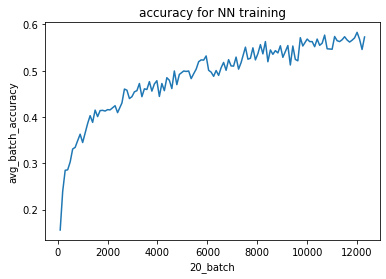

In [16]:
# draw the CNN training acc
iteration_acc_list = acc_list

# draw plot 
plt.plot([x[1] for x in iteration_acc_list], [y[0] for y in iteration_acc_list])

# set the label of X and y
plt.xlabel("20_batch")
plt.ylabel("avg_batch_accuracy")

# set the title of plot 
plt.title("accuracy for NN training")

Text(0.5, 1.0, 'cost for NN validation')

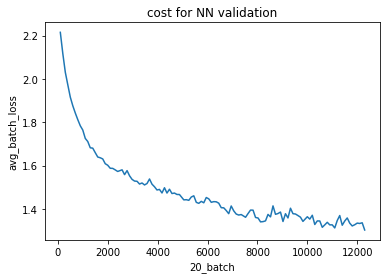

In [17]:
# draw the CNN validation cost
iteration_loss_list = loss_list_val

# draw plot 
plt.plot([x[1] for x in iteration_loss_list], [y[0] for y in iteration_loss_list])

# set the label of X and y
plt.xlabel("20_batch")
plt.ylabel("avg_batch_loss")

# set the title of plot 
plt.title("cost for NN validation")

Text(0.5, 1.0, 'accuracy for NN validation')

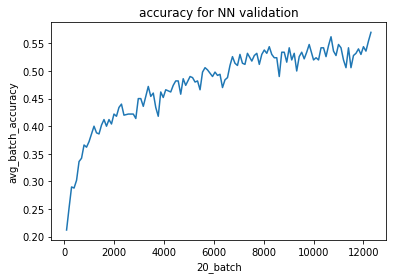

In [18]:
# draw the CNN validation acc
iteration_acc_list = acc_list_val

# draw plot 
plt.plot([x[1] for x in iteration_acc_list], [y[0] for y in iteration_acc_list])

# set the label of X and y
plt.xlabel("20_batch")
plt.ylabel("avg_batch_accuracy")

# set the title of plot 
plt.title("accuracy for NN validation")

### Save Model

In [19]:
# save the model
torch.save(net.state_dict(), "Q1_NN.pth")
print("Saved")

Saved


### Load Saved Model

In [20]:
net = NeuralNetwork()
net.load_state_dict(torch.load("Q1_NN.pth"))

<All keys matched successfully>

### Test

In [21]:
# test all the test data
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(images)
    correct += compute_acc(outputs, labels)
    total += 1

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 52 %


In [22]:
# test all the test data based on differnt classification
# prepare to count predictions for each class
correct_pred = {_name: 0 for _name in classes}
total_pred = {_name: 0 for _name in classes}
y_true = []
y_pred = []

for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    y_true += labels.tolist()
    y_pred += predictions.tolist()
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

# print accuracy for each classification
for _name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[_name]
    print("Accuracy for class {:5s} is: {:.1f} %".format(_name,accuracy))

Accuracy for class plane is: 57.3 %
Accuracy for class car   is: 66.4 %
Accuracy for class bird  is: 39.9 %
Accuracy for class cat   is: 38.3 %
Accuracy for class deer  is: 31.6 %
Accuracy for class dog   is: 42.7 %
Accuracy for class frog  is: 68.7 %
Accuracy for class horse is: 61.9 %
Accuracy for class ship  is: 67.1 %
Accuracy for class truck is: 55.1 %


In [26]:
# confusion matrix
def evaluation(y_true,y_pred,classes):
    judge = classification_report(y_true, y_pred,target_names=classes)
    print(judge)
    #confusion matrix
    classes = classes
    confusion = confusion_matrix(y_true, y_pred)
    plt.imshow(confusion, cmap=plt.cm.Greens)
    indices = range(len(confusion))
    plt.xticks(indices, classes)
    plt.yticks(indices, classes)
    plt.colorbar()
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
    for first_index in range(len(confusion)):
        for second_index in range(len(confusion[first_index])):
            plt.text(first_index, second_index, confusion[first_index][second_index])
    plt.show()

              precision    recall  f1-score   support

       plane       0.63      0.57      0.60      1000
         car       0.62      0.66      0.64      1000
        bird       0.43      0.40      0.41      1000
         cat       0.37      0.38      0.38      1000
        deer       0.53      0.32      0.40      1000
         dog       0.45      0.43      0.44      1000
        frog       0.49      0.69      0.57      1000
       horse       0.56      0.62      0.59      1000
        ship       0.63      0.67      0.65      1000
       truck       0.58      0.55      0.57      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.52     10000
weighted avg       0.53      0.53      0.52     10000



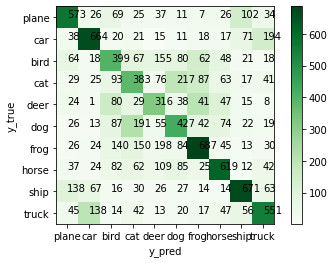

In [27]:
evaluation(y_true,y_pred,classes)

### Fully Connected Network Model Set (Imporved)

In [28]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32,768),
            nn.ReLU(),
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 384),
            nn.ReLU(),
            nn.Linear(384, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

net = NeuralNetwork()

In [29]:
# show the information of the NN
print("NN Model Information:",net)

NN Model Information: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=768, bias=True)
    (1): ReLU()
    (2): Linear(in_features=768, out_features=768, bias=True)
    (3): ReLU()
    (4): Linear(in_features=768, out_features=384, bias=True)
    (5): ReLU()
    (6): Linear(in_features=384, out_features=10, bias=True)
  )
)


In [30]:
# visualize the layer,download the pdf
import torch
from torchviz import make_dot
x = torch.rand(20,3,32,32)
g = make_dot(net(x))
g.render('CIFAR10_NN_Model_Improved', view=True)

'CIFAR10_NN_Model_Improved.pdf'

In [31]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [32]:
# create the required list
loss_list = []
acc_list = []
loss_list_val = []
acc_list_val = []
interation_times = 0

In [33]:
# compute acc
def compute_acc(outputs, labels):
    max_list = []
    tmp_list = []
    _, predicted = torch.max(outputs, 1)
    max_list = predicted.tolist()
    for i in range(len(max_list)):
        if max_list[i] == labels[i]:
            tmp_list.append(1)
        else:
            tmp_list.append(0)
    return sum(tmp_list)/len(tmp_list)

In [34]:
for epoch in tqdm(range(7)): 
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the training data
        inputs, labels = data
        # initilize the parameter
        optimizer.zero_grad()

        # forward,backward and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # record statistics
        interation_times += 1
        running_loss += loss.item()
        running_acc += compute_acc(outputs, labels)
        if i % 100 == 99:
            loss_list.append([running_loss / 100,interation_times])
            acc_list.append([running_acc / 100,interation_times])
            running_loss = 0.0
            running_acc = 0.0
            
            #validation
            loss_val = 0; correct_val = 0; total = 0
            for data in validationloader:
                images, labels = data
                outputs = net(images)
                loss_val += criterion(outputs, labels).item()
                correct_val += compute_acc(outputs, labels)
                total += 1

            loss_list_val.append([loss_val / total,interation_times])
            acc_list_val.append([correct_val / total,interation_times])
                
print('Finished Training')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [07:09<00:00, 61.34s/it]


Finished Training


Text(0.5, 1.0, 'cost for NN training')

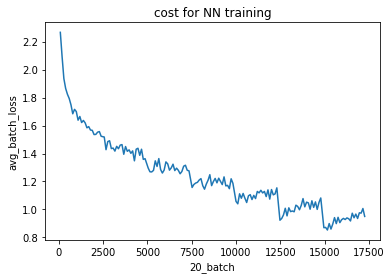

In [35]:
# draw the CNN training cost
iteration_loss_list = loss_list

# draw plot 
plt.plot([x[1] for x in iteration_loss_list], [y[0] for y in iteration_loss_list])

# set the label of X and y
plt.xlabel("20_batch")
plt.ylabel("avg_batch_loss")

# set the title of plot 
plt.title("cost for NN training")

Text(0.5, 1.0, 'accuracy for NN training')

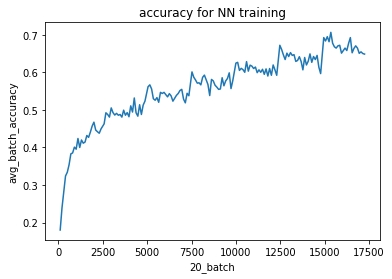

In [36]:
# draw the CNN training acc
iteration_acc_list = acc_list

# draw plot 
plt.plot([x[1] for x in iteration_acc_list], [y[0] for y in iteration_acc_list])

# set the label of X and y
plt.xlabel("20_batch")
plt.ylabel("avg_batch_accuracy")

# set the title of plot 
plt.title("accuracy for NN training")

Text(0.5, 1.0, 'cost for NN validation')

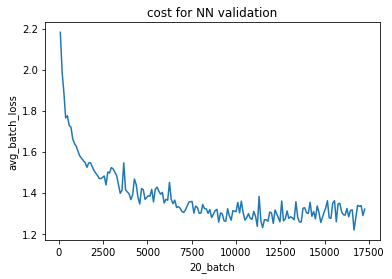

In [37]:
# draw the CNN validation cost
iteration_loss_list = loss_list_val

# draw plot 
plt.plot([x[1] for x in iteration_loss_list], [y[0] for y in iteration_loss_list])

# set the label of X and y
plt.xlabel("20_batch")
plt.ylabel("avg_batch_loss")

# set the title of plot 
plt.title("cost for NN validation")

Text(0.5, 1.0, 'accuracy for NN validation')

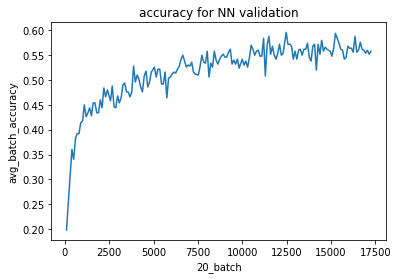

In [38]:
# draw the CNN validation acc
iteration_acc_list = acc_list_val

# draw plot 
plt.plot([x[1] for x in iteration_acc_list], [y[0] for y in iteration_acc_list])

# set the label of X and y
plt.xlabel("20_batch")
plt.ylabel("avg_batch_accuracy")

# set the title of plot 
plt.title("accuracy for NN validation")

### Save, Read and Test

In [39]:
# save the model
torch.save(net.state_dict(), "Q1_NN_Improved.pth")
print("Saved")

Saved


In [40]:
net = NeuralNetwork()
net.load_state_dict(torch.load("Q1_NN_Improved.pth"))

<All keys matched successfully>

In [41]:
# test all the test data
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(images)
    correct += compute_acc(outputs, labels)
    total += 1

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 55 %


In [42]:
# test all the test data based on differnt classification
# prepare to count predictions for each class
correct_pred = {_name: 0 for _name in classes}
total_pred = {_name: 0 for _name in classes}
y_true = []
y_pred = []

for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    y_true += labels.tolist()
    y_pred += predictions.tolist()
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

# print accuracy for each classification
for _name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[_name]
    print("Accuracy for class {:5s} is: {:.1f} %".format(_name,accuracy))

Accuracy for class plane is: 69.5 %
Accuracy for class car   is: 64.3 %
Accuracy for class bird  is: 44.3 %
Accuracy for class cat   is: 44.3 %
Accuracy for class deer  is: 38.9 %
Accuracy for class dog   is: 46.3 %
Accuracy for class frog  is: 58.9 %
Accuracy for class horse is: 62.1 %
Accuracy for class ship  is: 67.8 %
Accuracy for class truck is: 54.7 %


              precision    recall  f1-score   support

       plane       0.57      0.69      0.62      1000
         car       0.68      0.64      0.66      1000
        bird       0.47      0.44      0.46      1000
         cat       0.35      0.44      0.39      1000
        deer       0.52      0.39      0.45      1000
         dog       0.45      0.46      0.46      1000
        frog       0.58      0.59      0.59      1000
       horse       0.66      0.62      0.64      1000
        ship       0.66      0.68      0.67      1000
       truck       0.64      0.55      0.59      1000

    accuracy                           0.55     10000
   macro avg       0.56      0.55      0.55     10000
weighted avg       0.56      0.55      0.55     10000



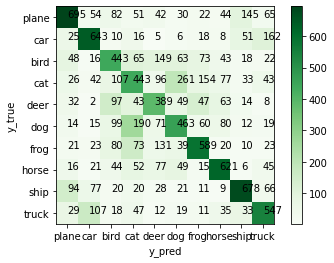

In [43]:
evaluation(y_true,y_pred,classes)

### CNN Model Set

In [44]:
# refer link: https://pytorch.org/vision/master/_modules/torchvision/models/alexnet.html
import torch.nn as nn
import torch.nn.functional as F

In [45]:
# use GPU to train
import torch
print(torch.cuda.is_available())
device = torch.device('cuda:0')
print(device)
#model.to(device)

True
cuda:0


In [46]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            #nn.Dropout(p=dropout),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
net = Net()

In [47]:
# show the information of the CNN
print("CNN Model Information:",net)

CNN Model Information: Net(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [48]:
# visualize the layer,download the pdf
import torch
from torchviz import make_dot
x = torch.rand(4,3,32,32)
g = make_dot(net(x))
g.render('CIFAR10_CNN_Model', view=True)

'CIFAR10_CNN_Model.pdf'

### CNN_Train

In [65]:
# Trun to GPU
# net.to(device)

In [66]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [67]:
# create the required list
loss_list = []
acc_list = []
interation_times = 0

In [68]:
# compute acc
def compute_acc(outputs, labels):
    max_list = []
    tmp_list = []
    _, predicted = torch.max(outputs, 1)
    max_list = predicted.tolist()
    for i in range(len(max_list)):
        if max_list[i] == labels[i]:
            tmp_list.append(1)
        else:
            tmp_list.append(0)
    return sum(tmp_list)/len(tmp_list)

In [69]:
for epoch in tqdm(range(8)): 
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the training data
        inputs, labels = data
        # initilize the parameter
        optimizer.zero_grad()

        # forward,backward and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # record statistics
        interation_times += 1
        running_loss += loss.item()
        running_acc += compute_acc(outputs, labels)
        if i % 100 == 99:
            loss_list.append([running_loss / 100,interation_times])
            acc_list.append([running_acc / 100,interation_times])
            running_loss = 0.0
            running_acc = 0.0

print('Finished Training')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:44<00:00, 50.58s/it]


Finished Training


Text(0.5, 1.0, 'cost for CNN training')

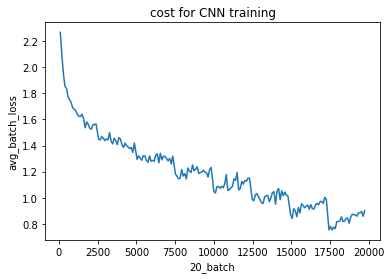

In [70]:
# draw the CNN training cost
iteration_loss_list = loss_list

# draw plot 
plt.plot([x[1] for x in iteration_loss_list], [y[0] for y in iteration_loss_list])

# set the label of X and y
plt.xlabel("20_batch")
plt.ylabel("avg_batch_loss")

# set the title of plot 
plt.title("cost for CNN training")

Text(0.5, 1.0, 'accuracy for CNN training')

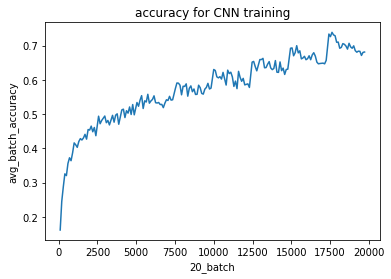

In [71]:
# draw the CNN training acc
iteration_acc_list = acc_list

# draw plot 
plt.plot([x[1] for x in iteration_acc_list], [y[0] for y in iteration_acc_list])

# set the label of X and y
plt.xlabel("20_batch")
plt.ylabel("avg_batch_accuracy")

# set the title of plot 
plt.title("accuracy for CNN training")

In [72]:
# save the model
torch.save(net.state_dict(), "Q1_CNN_Improved.pth")
print("Saved")

Saved


In [73]:
net = NeuralNetwork()
net.load_state_dict(torch.load("Q1_CNN_Improved.pth"))

<All keys matched successfully>

### CNN_Test

In [74]:
# small test to show the result
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted:', ','.join('%s' % classes[predicted[j]] for j in range(10)))

Predicted: plane,bird,cat,plane,horse,dog,car,ship,ship,bird


In [75]:
# test all the test data
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(images)
    correct += compute_acc(outputs, labels)
    total += 1

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 55 %


In [76]:
# test all the test data based on differnt classification
# prepare to count predictions for each class
correct_pred = {_name: 0 for _name in classes}
total_pred = {_name: 0 for _name in classes}
y_true = []
y_pred = []

for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    y_true += labels.tolist()
    y_pred += predictions.tolist()
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

# print accuracy for each classification
for _name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[_name]
    print("Accuracy for class {:5s} is: {:.1f} %".format(_name,accuracy))

Accuracy for class plane is: 65.0 %
Accuracy for class car   is: 68.5 %
Accuracy for class bird  is: 48.1 %
Accuracy for class cat   is: 39.1 %
Accuracy for class deer  is: 44.0 %
Accuracy for class dog   is: 46.5 %
Accuracy for class frog  is: 55.0 %
Accuracy for class horse is: 60.3 %
Accuracy for class ship  is: 68.7 %
Accuracy for class truck is: 58.1 %


              precision    recall  f1-score   support

       plane       0.60      0.65      0.62      1000
         car       0.66      0.69      0.67      1000
        bird       0.43      0.48      0.46      1000
         cat       0.38      0.39      0.39      1000
        deer       0.47      0.44      0.45      1000
         dog       0.46      0.47      0.46      1000
        frog       0.66      0.55      0.60      1000
       horse       0.64      0.60      0.62      1000
        ship       0.66      0.69      0.67      1000
       truck       0.61      0.58      0.60      1000

    accuracy                           0.55     10000
   macro avg       0.56      0.55      0.55     10000
weighted avg       0.56      0.55      0.55     10000



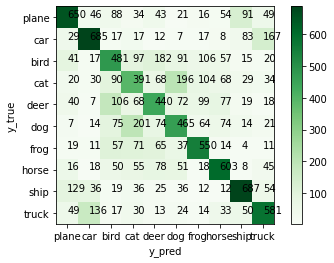

In [77]:
evaluation(y_true,y_pred,classes)